In [24]:
# Import libraries required to do operations like convolution, gaussian blur, sobel operator, pixel manipulation, etc.

import math
import timeit
import matplotlib.image as mpimg 
from scipy import misc
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt

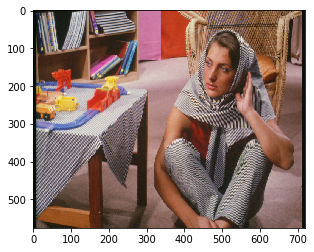

In [25]:
# Load image into variable and display it

eins = mpimg.imread(r"\Users\Kaustav Dutta\Desktop\Test.png");
plt.imshow(eins)

In [26]:
eins.shape #shape x ncols

(576, 720, 3)

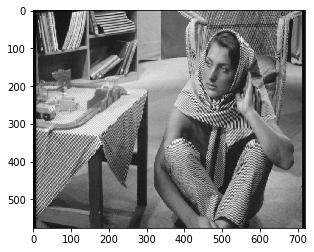

In [27]:
# Convert color image to grayscale to help extraction of edges

eins_gray = np.dot(eins, [1,1,1])
plt.imshow(eins_gray ,cmap = plt.get_cmap('gray'));

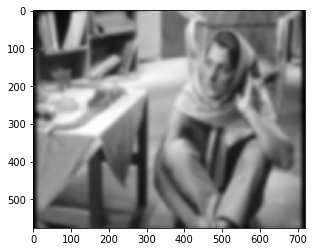

In [28]:
# Blur the grayscale image so that only important edges are extracted and the noisy ones ignored
# filter signature: ndimage.gaussian_filter(input, sigma, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)

eins_gray_blurred = ndimage.gaussian_filter(eins_gray, sigma=5) # sigma is image-specific, check!
plt.imshow(eins_gray_blurred, cmap = plt.get_cmap('gray'));

In [29]:
# the magnitude of filter (here 5) is proportional to how aggressive the edge extraction is

def SobelFilter(img, direction):
    if(direction == 'x'):
        Gx = np.array([[-1,0,+1], [-2,0,+2],  [-1,0,+1]])
        Res = ndimage.convolve(img, Gx) 
        #Res signature is ndimage.convolve(img, Gx, mode='constant', cval=0.0)
        
    if(direction == 'y'):
        Gy = np.array([[-1,-2,-1], [0,0,0], [+1,+2,+1]])
        Res = ndimage.convolve(img, Gy)
        
    if(direction == 'd1'):
        Gd1 = np.array([[0,+1,+2],[-1,0,+1],[-2,-1,0]])
        Res = ndimage.convolve(img, Gd1)
    
    if(direction == 'd2'):
        Gd2 = np.array([[-2,-1,0],[-1,0,+1],[0,+1,+2]])
        Res = ndimage.convolve(img, Gd2)
        
    return Res

In [30]:
# Normalize the pixel array, so that values are <= 1
def Normalize(img):
    img = img/np.max(img)
    return img

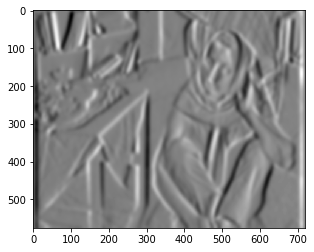

In [31]:
# Apply Sobel Filter in X direction
gx = SobelFilter(eins_gray_blurred, 'x')
gx = Normalize(gx)
plt.imshow(gx, cmap = plt.get_cmap('gray'));

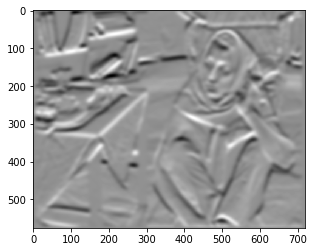

In [32]:
# Apply Sobel Filter in Y direction
gy = SobelFilter(eins_gray_blurred, 'y')
gy = Normalize(gy)
plt.imshow(gy, cmap = plt.get_cmap('gray'));

(576, 720)


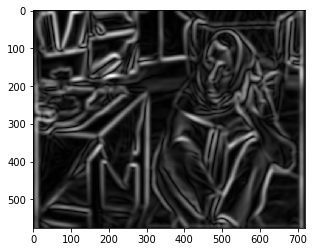

In [33]:
# Calculate the magnitude of the gradients obtained
Mag = np.hypot(gx,gy)
Mag = Normalize(Mag)
print(Mag.shape)
plt.imshow(Mag, cmap = plt.get_cmap('gray'))
plt.show()

In [35]:
# Calculate direction of the gradients
Gradient = np.degrees(np.arctan2(gy,gx))
#Gradient = np.arctan2(gy,gx)

In [36]:
# This is non-maxima suppression but without interpolation i.e. the pixel closest to the 
# gradient direction is used as the estimate

def NonMaxSupWithoutInterpol(Gmag,Grad,deg):
    pi= math.degrees(math.pi)
    alpha= np.array([deg/2,pi/4+(deg/2),pi/2+(deg/2),(3*pi/4)+(deg/2)])
    new=np.zeros((5,1),dtype=bool)
    NMS = np.zeros(Gmag.shape)
    A=np.array([[0,1,0,-1],[1,1,-1,-1],[1,0,-1,0],[1,-1,-1,1]]) #picks NN axis

    
    for i in range(0, int(Gmag.shape[0])-1):
        for j in range(0, int(Gmag.shape[1])-1):
            gr=Grad[i,j]
            for k in range(0, int(alpha.shape[0])):
                new[k]=np.logical_or(np.logical_and(gr>=alpha[k]-pi/4,gr<=alpha[k]),
                np.logical_and(gr<=alpha[k]-pi,gr>=alpha[k]-5*pi/4))
                new[4]=np.logical_or(gr<=-pi+alpha[0],gr>=pi-alpha[0])
            
            trueindex=np.where(new)[0][0];
            trueindex=np.where(trueindex==4,0,trueindex)
       
            NMS[i,j]=np.where(np.logical_and((Gmag[i,j] > Gmag[i+A[trueindex,0],j+A[trueindex,1]]),
                                         (Gmag[i,j] > Gmag[i+A[trueindex,2],j+A[trueindex,3]]))
                                        ,Gmag[i,j],0)  
        #print (NMS[i,j])
        
    return NMS

Get the Non-Max Suppressed output; may take ~30s

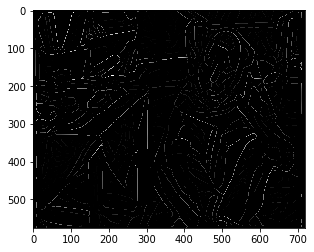

In [37]:
deg=45; #set deg>=45
NMS1 = NonMaxSupWithoutInterpol(Mag, Gradient,deg);
NMS1= Normalize(NMS1);
plt.imshow(NMS1, cmap = plt.get_cmap('gray'));

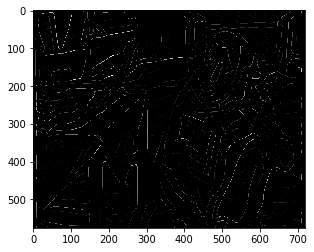

In [38]:
deg=135; #set deg>=45
NMS2 = NonMaxSupWithoutInterpol(Mag, Gradient,deg);
NMS2= Normalize(NMS2);
plt.imshow(NMS2, cmap = plt.get_cmap('gray'));

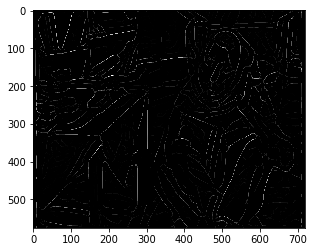

In [39]:
NMStot=(NMS1+NMS2)/2;
plt.imshow(NMStot, cmap = plt.get_cmap('gray'));

In [ ]:
def DoThreshHyst(img):
    highThresholdRatio = 0.3  
    lowThresholdRatio = 0.05 
    GSup = np.copy(img)
    h = int(GSup.shape[0])
    w = int(GSup.shape[1])
    highThreshold = np.max(GSup)*highThresholdRatio
    lowThreshold = highThreshold*lowThresholdRatio    
    x = 0.1
    oldx=0
    
    # The while loop is used so that the loop will keep executing till the number of strong edges 
    # do not change, i.e all weak edges connected to strong edges have been found
    while(oldx != x):
        oldx = x
        for i in range(1,h-1):
            for j in range(1,w-1):
                GSup[i,j]=(np.where((GSup[i,j] > highThreshold),1,(np.where(GSup[i,j])<highThreshold,0))
                if (np.logical_or(GSup[i,j]==1,GSup[i,j]==0)):
                    count=True
                if (count!=True):
                    GSup[i,j]=(np.where(((GSup[i-1,j-1] > highThreshold) or (GSup[i-1,j] > highThreshold) or(GSup[i-1,j+1] > highThreshold) or(GSup[i,j-1] > highThreshold) or(GSup[i,j+1] > highThreshold) or(GSup[i+1,j-1] > highThreshold) or(GSup[i+1,j] > highThreshold) or(GSup[i+1,j+1] > highThreshold)),1))

        x = np.sum(GSup == 1)
    
    GSup = (GSup == 1) * GSup # This is done to remove/clean all the "weak" edges which are not connected to strong edges
    
    return GSup

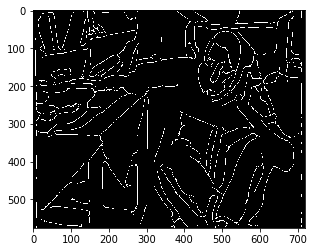

In [44]:
# The output of canny edge detection: takes around 40 seconds

Final_Image = DoThreshHyst(NMStot)
plt.imshow(Final_Image, cmap = plt.get_cmap('gray'))
plt.show()

In [43]:
Final_Image.sum()

19910.0